## Neural Network (Score: 0.70574)

In [23]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score

DATA_PATH = '../data/'
MODEL_PARAMS_PATH = 'params/'
SUBMISSIONS_PATH = '../submissions/'

In [2]:
# define custom dataset class for Titanic CSV dataset
class TitanicDataset(Dataset):
    def __init__(self, path):
        data = pd.read_csv(path)
        self.X = data.drop('Survived', axis=1)
        self.y = data['Survived']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [
            self.X.loc[idx].values.astype(np.float32),
            self.y[idx].astype(np.float32)
        ]
    
    def get_splits(self, n_train=0.8):
        train_size = int(0.8 * len(train_data))
        valid_size = len(train_data) - train_size
        return random_split(train_data, [train_size, valid_size])

In [3]:
# load training and validation datasets
train_data = TitanicDataset(os.path.join(DATA_PATH + 'preprocessed_train.csv'))
train_data, valid_data = train_data.get_splits()

In [4]:
# prepare training and validation data loaders
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=1024, shuffle=False)

In [13]:
# define neural network model
class DenseLayer(nn.Module):
    def __init__(self, n_inputs, n_outputs, activation=nn.ReLU):
        super(DenseLayer, self).__init__()
        self.layer = nn.Linear(n_inputs, n_outputs)
        self.activation = activation()
        
    def forward(self, X):
        X = self.layer(X)
        X = self.activation(X)
        return X

class MLP(nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer = nn.Sequential(
            DenseLayer(n_inputs, 1024),
            DenseLayer(1024, 512),
            DenseLayer(512, 256),
            DenseLayer(256, 128),
            DenseLayer(128, 64),
            DenseLayer(64, 32),
            DenseLayer(32, 16),
            DenseLayer(16, 8),
            DenseLayer(8, 1, activation=nn.Sigmoid)
        )
        
    def forward(self, X):
        X = self.layer(X)
        return X
    
    def validate(self, dl):
        all_preds, all_targets = [], []
        for i, (inputs, targets) in enumerate(dl):
            preds = model(inputs).reshape(-1, 1).detach().numpy().round()
            targets = targets.reshape(-1, 1)
            all_preds.append(preds)
            all_targets.append(targets)
        all_preds, all_targets = np.vstack(all_preds), np.vstack(all_targets)
        acc = accuracy_score(all_targets, all_preds)
        return acc

In [14]:
# view model structure
model = MLP(10)
model

MLP(
  (layer): Sequential(
    (0): DenseLayer(
      (layer): Linear(in_features=10, out_features=1024, bias=True)
      (activation): ReLU()
    )
    (1): DenseLayer(
      (layer): Linear(in_features=1024, out_features=512, bias=True)
      (activation): ReLU()
    )
    (2): DenseLayer(
      (layer): Linear(in_features=512, out_features=256, bias=True)
      (activation): ReLU()
    )
    (3): DenseLayer(
      (layer): Linear(in_features=256, out_features=128, bias=True)
      (activation): ReLU()
    )
    (4): DenseLayer(
      (layer): Linear(in_features=128, out_features=64, bias=True)
      (activation): ReLU()
    )
    (5): DenseLayer(
      (layer): Linear(in_features=64, out_features=32, bias=True)
      (activation): ReLU()
    )
    (6): DenseLayer(
      (layer): Linear(in_features=32, out_features=16, bias=True)
      (activation): ReLU()
    )
    (7): DenseLayer(
      (layer): Linear(in_features=16, out_features=8, bias=True)
      (activation): ReLU()
    )
   

100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]

Learning Rate: 1e-03
Achieved at Epoch: 140/1000
Lowest Loss: 0.13979231
Highest Training Accuracy: 82.16%
Highest Validation Accuracy: 85.47%



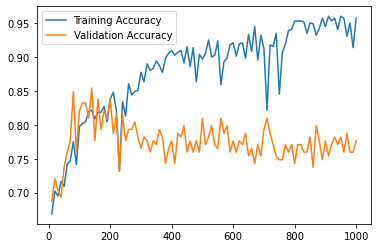

----------- BEST MODEL -----------
Learning Rate: 1e-03
Achieved at Epoch: 140/1000
Lowest Loss: 0.13979231
Highest Training Accuracy: 82.16%
Highest Validation Accuracy: 85.47%



In [39]:
# hyperparameters
# lrs = [10**-i for i in range(7)]
lrs = [1e-3]
epochs = 1000
x_points = [i for i in range(10, epochs+1, 10)]
y_train_points = []
y_valid_points = []

global_lowest_loss = float('inf')
global_highest_valid_acc = 0

# train/validate model
for lr in lrs:
    # reset model
    model = MLP(10)

    # loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_epochs = 0
    local_lowest_loss = float('inf')
    local_highest_valid_acc = 0

    for epoch in tqdm(range(1, epochs+1)):
        # train model
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            preds = model(inputs).squeeze()
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()

        # validate model
        if epoch%10 == 0:
            train_acc = model.validate(train_dl)
            valid_acc = model.validate(valid_dl)
            
            y_train_points.append(train_acc)
            y_valid_points.append(valid_acc)

            if loss < local_lowest_loss and valid_acc > local_highest_valid_acc:
                local_best_epochs = epoch
                local_lowest_loss = loss
                local_highest_train_acc = train_acc
                local_highest_valid_acc = valid_acc
                
            if loss < global_lowest_loss and valid_acc > global_highest_valid_acc:
                global_best_lr = lr
                global_best_epochs = epoch
                global_lowest_loss = loss
                global_highest_train_acc = train_acc
                global_highest_valid_acc = valid_acc
                torch.save(model.state_dict(), os.path.join(MODEL_PARAMS_PATH, 'neural_network.pt'))
                
    print("Learning Rate: %.0e" % (lr))
    print("Achieved at Epoch: " + str(local_best_epochs) + "/" + str(epochs))
    print("Lowest Loss: " + str(local_lowest_loss.detach().numpy()))
    print("Highest Training Accuracy: %.2f%%" % (local_highest_train_acc*100))
    print("Highest Validation Accuracy: %.2f%%" % (local_highest_valid_acc*100))
    print("")
    
    plt.plot(x_points, y_train_points, label="Training Accuracy")
    plt.plot(x_points, y_valid_points, label="Validation Accuracy")
    plt.legend()
    plt.show()
    
print("----------- BEST MODEL -----------")
print("Learning Rate: %.0e" % (global_best_lr))
print("Achieved at Epoch: " + str(global_best_epochs) + "/" + str(epochs))
print("Lowest Loss: " + str(global_lowest_loss.detach().numpy()))
print("Highest Training Accuracy: %.2f%%" % (global_highest_train_acc*100))
print("Highest Validation Accuracy: %.2f%%" % (global_highest_valid_acc*100))
print("")

In [17]:
# load test dataset
test_df = pd.read_csv(os.path.join(DATA_PATH, 'preprocessed_test.csv'))
test_data = torch.tensor(test_df.values).float()

In [18]:
# load best model and 
model.load_state_dict(torch.load(os.path.join(MODEL_PARAMS_PATH, 'neural_network.pt')))
model.eval()

# predict using test dataset
submission = pd.DataFrame()
submission['PassengerId'] = test_df['PassengerId']
submission['Survived'] = model(test_data).round().int().numpy()
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [19]:
# create submission file
submission.to_csv(os.path.join(SUBMISSIONS_PATH, 'neural_network.csv'), index=False)